In [52]:
import os
import time
from typing import List

import numpy as np
import torch
import torch.nn as nn

from src.models.embedding_model import EmbeddingModel
from src.models.rnn_soft_attention import RNNWithSoftAttention
from src.models.self_attention import SelfAttentionModel
from src.sst2_dataset import SimpleTokenizer, SST2Dataset
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

from scipy.spatial.distance import cosine
from sentimental_analysis import get_strong_sentiment_words

In [64]:
class HotFlipAttack:
    def __init__(self, model: nn.Module, tokenizer: SimpleTokenizer, get_strong_sentiment_words):
        self.model = model
        self.tokenizer = tokenizer
        self.forbidden_tokens = np.array([])
        self.get_strong_sentiment_words = get_strong_sentiment_words

    def add_forbidden_tokens_strong_sentiment(self, sentence: List[str], delta=0.2):
        words = self.get_strong_sentiment_words(sentence, delta)
        self.forbidden_tokens = np.array([])
        self.forbidden_tokens = np.append(self.forbidden_tokens, words)
        return (words, self.forbidden_tokens)

    def hotflip_attack(self, input_tokens, true_label, max_attempts=3):
        attemped_words_to_flip = np.array([], dtype="object")
        original_mode = self.model.training
        print("INPUT: ", input_tokens)
        self.model.train()

        input_ids = [self.tokenizer.word2idx.get(token, None) for token in input_tokens]
        input_ids = [id_ for id_ in input_ids if id_ is not None]  # filtering out the None values
        input_ids = torch.tensor(input_ids).unsqueeze(0).to(device)

        input_embeddings = self.model.get_input_embeddings()(input_ids)
        input_embeddings = input_embeddings.clone().detach().requires_grad_(True)
        outputs = self.model.forward_with_embeddings(input_embeddings)
        loss = nn.CrossEntropyLoss()(outputs, torch.tensor([true_label]).to(device))
        self.model.zero_grad()
        loss.backward()
        grads = input_embeddings.grad.data

        original_tokens = input_tokens.copy()

        # Create mask for forbidden tokens
        mask = torch.ones_like(input_ids, dtype=torch.bool)
        for forbidden_token in self.forbidden_tokens:
            forbidden_token_id = self.tokenizer.word2idx.get(forbidden_token, None)
            if forbidden_token_id is not None:
                mask &= (input_ids != forbidden_token_id)
        # Apply mask to gradients
        grads *= mask.unsqueeze(2)
        first_selected_token = 0
        for i in range(max_attempts):
            # Find the token with the highest gradient
            token_idx = torch.argmax(torch.sum(grads, dim=2))

            # Check if it's OOV. If so, set its gradient to -infinity and continue to the next loop iteration
            if input_tokens[token_idx] not in self.tokenizer.word2idx:
                grads[0, token_idx] = float('-inf')
                if i == 0:
                    first_selected_token = token_idx
                continue

            original_token = input_tokens[token_idx]
            best_replacement = self.get_best_replacement_token(grads[0, token_idx], original_token)

            # Replace the selected token with the best replacement
            input_tokens[token_idx] = best_replacement

            # Update mask for forbidden tokens
            mask = torch.ones_like(input_ids, dtype=torch.bool)
            for forbidden_token in self.forbidden_tokens:
                forbidden_token_id = self.tokenizer.word2idx.get(forbidden_token, None)
                if forbidden_token_id is not None:
                    mask &= (input_ids != forbidden_token_id)
            # Apply mask to gradients
            grads *= mask.unsqueeze(2)

            # Recompute prediction
            self.model.train(original_mode)

            input_ids = [self.tokenizer.word2idx.get(token, None) for token in input_tokens]
            input_ids = [id_ for id_ in input_ids if id_ is not None]  # filtering out the None values
            input_ids = torch.tensor(input_ids).unsqueeze(0).to(device)

            outputs, _ = self.model(input_ids)
            predicted_label = torch.argmax(outputs, dim=1).item()
            if predicted_label != true_label:
                attemped_words_to_flip = np.append(attemped_words_to_flip, "!" + best_replacement + "!")
                return input_tokens, token_idx.item(), attemped_words_to_flip
            else:
                input_tokens[token_idx] = original_tokens[token_idx]
                grads[0, token_idx] = float('-inf')
                attemped_words_to_flip = np.append(attemped_words_to_flip, best_replacement)
                break
        return input_tokens, first_selected_token, attemped_words_to_flip

    def get_best_replacement_token(self, grads, original_token):
        # Add original token to the forbidden tokens for this iteration

        current_forbidden_tokens = self.forbidden_tokens.copy()
        current_forbidden_tokens = np.append(current_forbidden_tokens, original_token)
        grads = grads.detach()
        original_token_id = self.tokenizer.word2idx[original_token]
        original_token_embedding = self.model.embedding(
            torch.tensor([original_token_id]).to(device)).detach()
        # Compute the cosine similarity between the original token embedding and all other token embeddings
        cosine_similarities = nn.functional.cosine_similarity(
            original_token_embedding,
            self.model.embedding.weight,
            dim=-1
        )

        # Compute the dot product between the gradients and all token embeddings
        dot_products = torch.matmul(grads, self.model.embedding.weight.t())

        # Create a boolean tensor that indicates whether each token is forbidden
        forbidden_tokens = torch.zeros_like(dot_products, dtype=torch.bool).to(device)
        for token, index in self.tokenizer.word2idx.items():
            if token in current_forbidden_tokens or token in stop_words:
                forbidden_tokens[index] = True

        # Find the token with the largest dot product that is not forbidden and has a cosine similarity above 0.8
        valid_tokens = (cosine_similarities >= 0.8) & ~forbidden_tokens
        valid_dot_products = dot_products[valid_tokens]
        if valid_dot_products.numel() == 0:  # no valid tokens
            # you can either return the original token id here,
            # or a random token id, depending on your preference.
            return self.tokenizer.convert_id_to_word(self.tokenizer.word2idx[original_token])
        best_replacement_index = torch.argmax(valid_dot_products)
        best_replacement_id = torch.arange(dot_products.shape[0]).to(device)[valid_tokens][best_replacement_index]

        best_replacement_token = self.tokenizer.convert_id_to_word(best_replacement_id.item())

        return best_replacement_token

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
device

device(type='cuda')

In [66]:
dataset = SST2Dataset(max_length=128)
hidden_dim = 256
output_dim = 2
rnn_soft_attention = RNNWithSoftAttention(dataset.embedding_matrix, hidden_dim, output_dim)
rnn_soft_attention.load_state_dict(torch.load('models/RNNWithSoftAttention.pth'))
# rnn_soft_attention = EmbeddingModel(dataset.embedding_matrix, hidden_dim, output_dim)
# rnn_soft_attention.load_state_dict(torch.load('models/EmbeddingModel.pth'))
# rnn_soft_attention = SelfAttentionModel(output_dim, dataset.embedding_matrix, max_length=256)
# rnn_soft_attention.load_state_dict(torch.load('models/SelfAttentionModel.pth'))
rnn_soft_attention = rnn_soft_attention.to(device)
attack = HotFlipAttack(model=rnn_soft_attention, tokenizer=dataset.tokenizer,
                       get_strong_sentiment_words=get_strong_sentiment_words)

attack_dataset = dataset.dataset['validation']

correct_predictions_before = 0
correct_predictions_after = 0
successes = 0
total = 0
attention_weights_list = []
perturbed_indices = []
original_sentences = []
original_labels = []
original_predictions = []
adversarial_sentences = []
adversarial_predictions = []
attempts_words_to_flip = []
adversarial_attention_weights_list = []
for example in attack_dataset:
    input_text = example['sentence']
    true_label = example['label']

    # Convert input text into tokens
    input_tokens = dataset.tokenizer.tokenize(input_text)
    attack.add_forbidden_tokens_strong_sentiment(input_text.split(), 0.2)
    # Get ids from tokens for model prediction
    # input_ids = torch.tensor([dataset.tokenizer.word2idx[token] for token in input_tokens]).unsqueeze(0).to(device)
    original_sentences.append(input_text)
    original_labels.append(true_label)

    input_ids = [dataset.tokenizer.word2idx.get(token, None) for token in input_tokens]
    input_ids = [id_ for id_ in input_ids if id_ is not None]  # filtering out the None values
    input_ids = torch.tensor(input_ids).unsqueeze(0).to(device)

    rnn_soft_attention.eval()
    with torch.no_grad():
        outputs, _ = rnn_soft_attention(input_ids)

    adversarial_tokens, perturbed_idx, attempts = attack.hotflip_attack(input_tokens, true_label)
    attempts_words_to_flip.append(attempts)
    original_prediction = outputs.argmax(dim=1).item()
    original_predictions.append(original_prediction)
    # attention_weights_list.append(attention_weights.cpu().numpy())  # Store attention weights
    perturbed_indices.append(perturbed_idx)  # Store perturbed indices

    adversarial_text = ' '.join(adversarial_tokens)
    adversarial_sentences.append(adversarial_text)
    # Convert adversarial tokens into ids for model prediction
    adversarial_input_ids = [dataset.tokenizer.word2idx.get(token, None) for token in adversarial_tokens]
    adversarial_input_ids = [id_ for id_ in adversarial_input_ids if id_ is not None]  # filtering out the None values
    adversarial_input_ids = torch.tensor(adversarial_input_ids).unsqueeze(0).to(device)

    rnn_soft_attention.eval()
    with torch.no_grad():
        adversarial_outputs, _ = rnn_soft_attention(adversarial_input_ids)
        adversarial_prediction = adversarial_outputs.argmax(dim=1).item()
    adversarial_predictions.append(adversarial_prediction)
    # adversarial_attention_weights_list.append(adversarial_attention_weights)
    if adversarial_prediction != original_prediction:
        successes += 1
        print("Attack succeeded")
    if original_prediction == true_label:
        correct_predictions_before += 1
    if adversarial_prediction == true_label:
        correct_predictions_after += 1
    total += 1
    print(total)

attempts_words_to_flip = [','.join(map(str, arr)) for arr in attempts_words_to_flip]

print(f'Attack success rate: {successes / total * 100:.2f}%')
print(f'Accuracy before attack: {correct_predictions_before / total * 100:.2f}%')
print(f'Accuracy after attack: {correct_predictions_after / total * 100:.2f}%')

Found cached dataset sst2 (C:/Users/Alex/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5)


  0%|          | 0/3 [00:00<?, ?it/s]

strong sentiment word charming
INPUT:  ['it', "'s", 'a', 'charming', 'and', 'often', 'affecting', 'journey', '.']
1
strong sentiment word desperate
INPUT:  ['unflinchingly', 'bleak', 'and', 'desperate']
2
strong sentiment word hope
strong sentiment word poised
INPUT:  ['allows', 'us', 'to', 'hope', 'that', 'nolan', 'is', 'poised', 'to', 'embark', 'a', 'major', 'career', 'as', 'a', 'commercial', 'yet', 'inventive', 'filmmaker', '.']
3
strong sentiment word astounding
INPUT:  ['the', 'acting', ',', 'costumes', ',', 'music', ',', 'cinematography', 'and', 'sound', 'are', 'all', 'astounding', 'given', 'the', 'production', "'s", 'austere', 'locales', '.']
4
INPUT:  ['it', "'s", 'slow', '--', 'very', ',', 'very', 'slow', '.']
5
strong sentiment word humor
INPUT:  ['although', 'laced', 'with', 'humor', 'and', 'a', 'few', 'fanciful', 'touches', ',', 'the', 'film', 'is', 'a', 'refreshingly', 'serious', 'look', 'at', 'young', 'women', '.']
6
INPUT:  ['a', 'sometimes', 'tedious', 'film', '.']
7
IN

In [46]:
differing_indices = [i for i, (x, y) in enumerate(zip(adversarial_predictions, original_predictions)) if x != y]
print(differing_indices)

[14, 24, 29, 38, 44, 45, 57, 69, 77, 108, 132, 133, 142, 145, 147, 160, 173, 182, 208, 211, 223, 224, 232, 233, 250, 264, 272, 273, 289, 293, 309, 332, 338, 339, 347, 362, 374, 377, 381, 398, 401, 402, 411, 433, 454, 463, 477, 486, 522, 527, 541, 548, 551, 552, 564, 569, 592, 595, 602, 615, 622, 634, 636, 645, 663, 689, 712, 718, 725, 748, 778, 785, 802, 824, 847, 851, 867, 871]


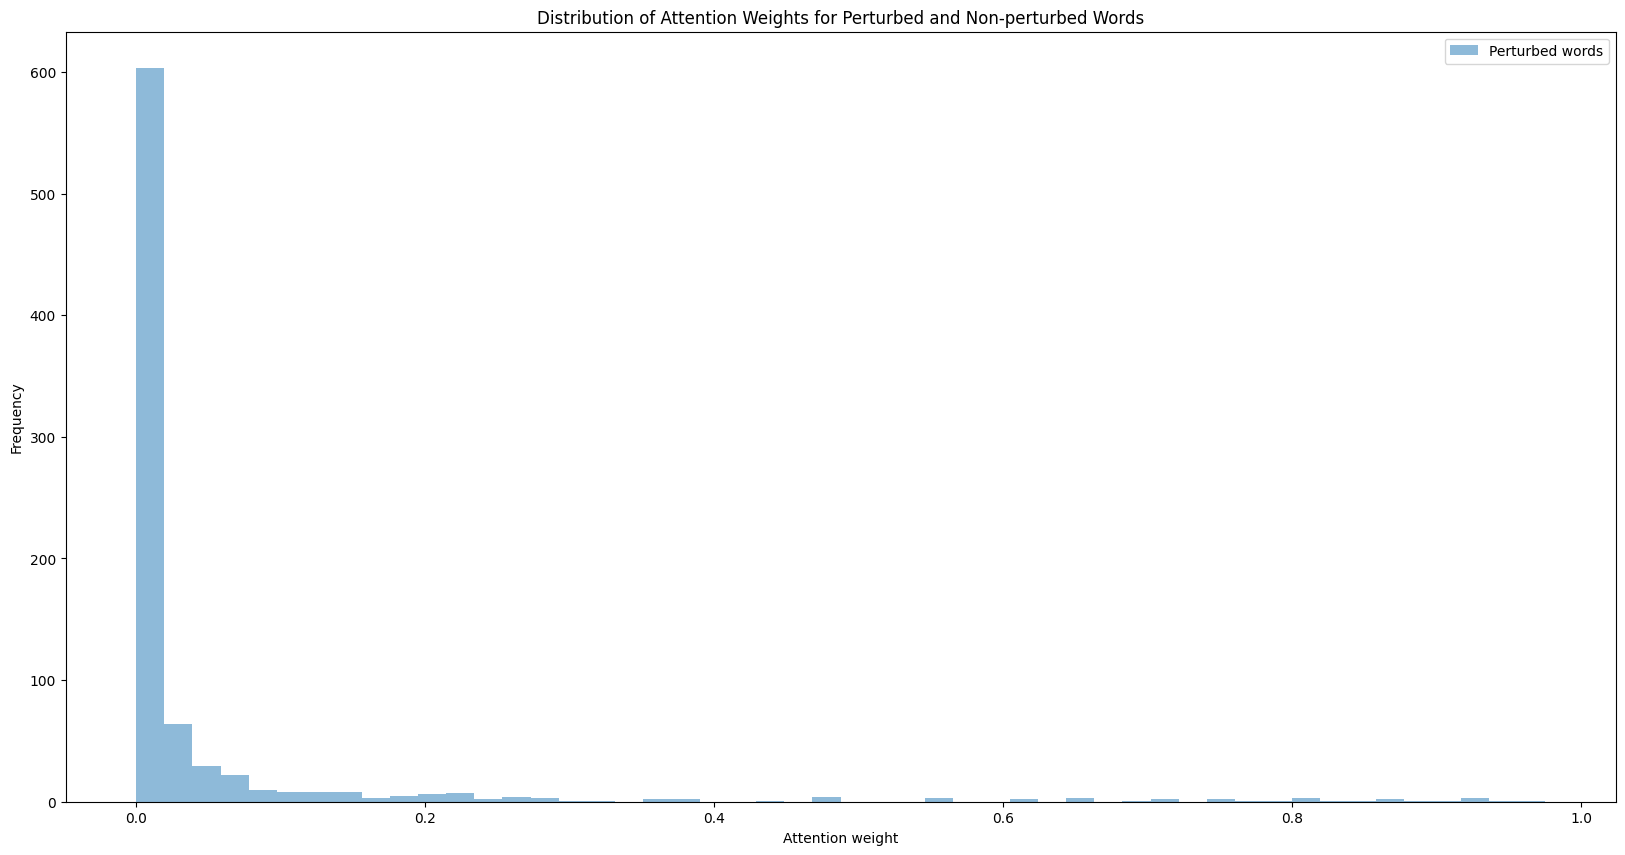

In [12]:
import matplotlib.pyplot as plt

def get_accumulated_weights_and_positions(attention_weights_list, perturbed_indices, sentences):
    all_weights = []
    all_positions = []
    all_words = []
    for i in range(len(sentences)):
        sentence = sentences[i].split(' ')
        attention_weights = attention_weights_list[i].flatten()[:len(sentence)]
        all_weights.extend(attention_weights)
        perturbed_index = perturbed_indices[i]
        all_positions.extend([1 if idx == perturbed_index else 0 for idx in range(len(sentence))])
        all_words.extend(sentence)
    return all_weights, all_positions, all_words

all_weights, all_positions, all_words = get_accumulated_weights_and_positions(attention_weights_list, perturbed_indices, original_sentences)

# Plot attention weights and perturbation positions
plt.figure(figsize=(20, 10))
# plt.hist([all_weights[i] for i in range(len(all_weights)) if all_positions[i] == 0], bins=50, alpha=0.5, label='Non-perturbed words')
plt.hist([all_weights[i] for i in range(len(all_weights)) if all_positions[i] == 1], bins=50, alpha=0.5, label='Perturbed words')
plt.title('Distribution of Attention Weights for Perturbed and Non-perturbed Words')
plt.xlabel('Attention weight')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()


['pumpkin', 'takes', 'an', 'admirable', 'look', 'at', 'the', 'hypocrisy', 'of', 'political', 'correctness', ',', 'but', 'it', 'does', 'so', 'with', 'such', 'an', 'uneven', 'tone', 'that', 'you', 'never', 'know', 'when', 'humor', 'ends', 'and', 'tragedy', 'begins', '.']
[2.3715035e-03 9.8488724e-04 2.6394175e-03 3.8439816e-01 1.5350282e-02
 2.2740854e-02 4.3041576e-04 1.7294396e-02 3.8074020e-05 1.1979933e-04
 8.0038508e-04 7.3715411e-05 3.9157114e-04 6.4581889e-04 2.8799908e-02
 2.4855868e-03 1.3519566e-03 2.2600198e-03 5.2127149e-03 3.4123510e-01
 2.2358801e-02 1.4548771e-03 1.9334745e-02 8.5171148e-02 2.7830843e-02
 4.6348213e-03 1.7308114e-03 8.2893195e-05 5.8730179e-06 2.2071591e-03
 5.5129430e-03 5.0407853e-05]
32 32


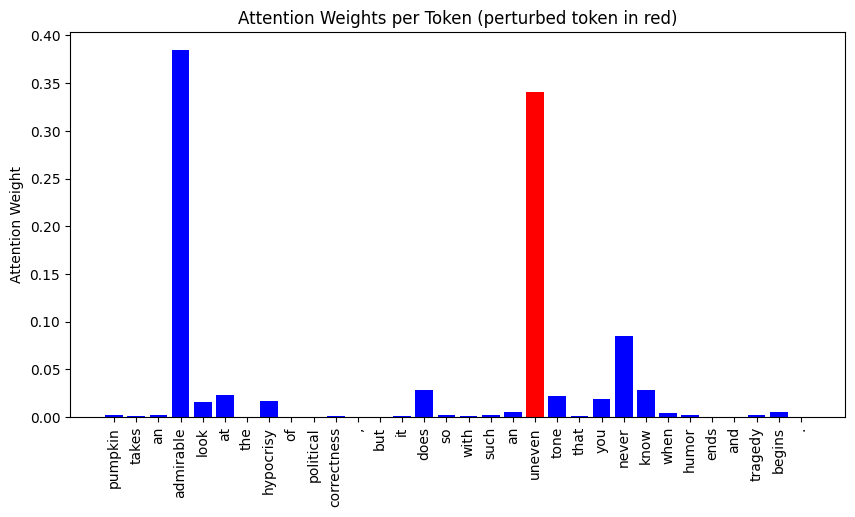

In [55]:
import matplotlib.pyplot as plt
import numpy as np

# 20
sentence_index = 20


weights = attention_weights_list[sentence_index].flatten()


perturbed_index = perturbed_indices[sentence_index]

tokens = original_sentences[sentence_index].split()

# Make sure that the attention weights and tokens have the same size
print(tokens)
print(weights)
print(len(weights), len(tokens))
# assert len(weights) == len(tokens)

# Create a color map where the perturbed index is highlighted
colors = ['b'] * len(tokens)
colors[perturbed_index] = 'r'

# Create a plot
plt.figure(figsize=(10, 5))
plt.bar(np.arange(len(tokens)), weights, color=colors)
plt.xticks(np.arange(len(tokens)), tokens, rotation=90)
plt.ylabel('Attention Weight')
plt.title('Attention Weights per Token (perturbed token in red)')
plt.show()


In [69]:
attempts_words_to_flip


['also',
 'unflinchingly',
 'another',
 'taken',
 'good',
 'serious',
 'laborious',
 'well',
 'wanted',
 'sunk',
 'leads',
 'gives',
 'enough',
 'another',
 '!.!',
 'from',
 'whose',
 'one',
 'nothing',
 'resembling',
 '!uneven!',
 'lasts',
 "n't",
 'filled',
 "!n't!",
 'nicks',
 'something',
 'at',
 'cookie-cutter',
 '!,!',
 'less',
 'yawns',
 'also',
 '!could!',
 "n't",
 'sequences',
 'another',
 '!demands!',
 '!time!',
 'hollywood',
 'one',
 'underneath',
 'reality',
 'first',
 '!others!',
 '!offer!',
 'decadent',
 ')',
 'of',
 'hindered',
 'tarted',
 'well-produced',
 'one',
 'one',
 'devoid',
 'family',
 'well',
 '!definitely!',
 'well',
 'superficial',
 'even',
 'persistently',
 'from',
 'one',
 'distended',
 'videos',
 'tickets',
 '.',
 'old-fashioned',
 '!films!',
 'head',
 'one',
 'able',
 'rivaling',
 'since',
 'of',
 'movies',
 '!even!',
 'would',
 'bus',
 'one',
 'burglary',
 '!little!',
 'leigh',
 'one',
 'time',
 'decadent',
 'wiretapping',
 'also',
 'one',
 'one',
 'leas